In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,inspect
# current_dir = '/home/jiayuand/seqOED_variational/examples/location'
# parent_dir = '/home/jiayuand/seqOED_variational'

# current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
# parent_dir = os.path.dirname(os.path.dirname(current_dir))
parent_dir = '../../../'
sys.path.insert(0, parent_dir) 

import numpy as np
# from scipy.stats import norm, beta, dirichlet
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from   torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
if torch.cuda.is_available():  
    dev = "cuda" 
else:  
    dev = "cpu"  
device = torch.device(dev) 
torch.set_default_device(device)
dtype = torch.float32
torch.set_default_dtype(dtype)

from vsOED import VSOED, PGvsOED, GMM_NET, NFs, POST_APPROX
from vsOED.utils import *
from vsOED.models import *
from vsOED.conv_diff import *

import dowel
import joblib

print('==============================================================================')
print('Please go to /home/<USER>/.local/lib/python3.9/site-packages/torch/storage.py')
print('and change def _load_from_bytes(b):')
print('to')
print(f'    return torch.load(io.BytesIO(b), map_location="{dev}")')
print('==============================================================================')

Please go to /home/<USER>/.local/lib/python3.9/site-packages/torch/storage.py
and change def _load_from_bytes(b):
to
    return torch.load(io.BytesIO(b), map_location="cpu")


# Only interested in parameter of interest (poi)

In [2]:
data_folder = parent_dir + './results/conv_diff/unimodel/poi/'
subfolders = {'rl': './RL_BOED/',
              'gmm': data_folder + 'GMM/',
              'nfs': data_folder + 'NFs/'}

In [3]:
# read in gmm results
hs = [1, 5, 10, 15, 20]
gmm_rwds = {}
for mode in ('terminal', 'incre'):
    gmm_rwds[mode] = np.full((4, 5), np.nan)
    for id in range(4):
        for k, h in enumerate(hs):
            try:
                res = torch.load(subfolders['gmm'] + f'/{mode}_id{id}_h{h}/evaluation_with_post_approx.pt', map_location=device)
                gmm_rwds[mode][id, k] = res['averaged_reward']
            except:
                pass
        

/tmp/ipykernel_1441802/1872831983.py:6: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(gmm_rwds[mode], axis=0)


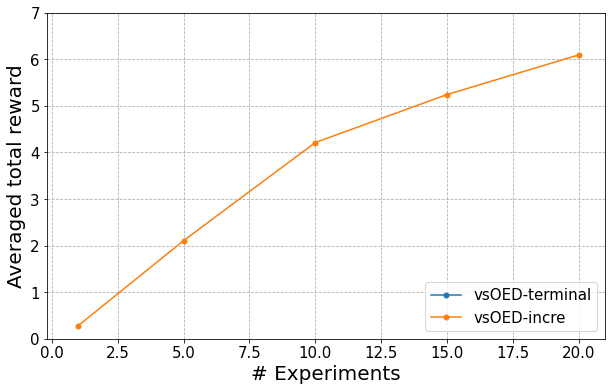

In [6]:
# draw evaluation of each T, compared with limited training
plt.figure(figsize=(10, 6))
markersize = 5
markers = {'gmm':'o'}
for mode in ['terminal', 'incre']:
    mean = np.nanmean(gmm_rwds[mode], axis=0)
    plt.plot(hs, mean, marker=markers['gmm'], markersize=markersize, label=f'vsOED-{mode}', zorder=100)
    # plt.fill_between(hs, mean-2*se, mean+2*se, alpha=0.5, zorder=100)

plt.legend(fontsize=15, loc=4)
plt.xlabel('# Experiments', fontsize=20)
plt.ylabel('Averaged total reward', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(-0.2, 21)
plt.ylim(0, 7)
plt.grid(ls='--')
plt.show()

In [8]:
# pick a mode , id and horizon, and load the data
post_net_type = 'gmm'
mode = 'incre'
id = 0
h = 15
subfolder = subfolders[post_net_type] + f'/{mode}_id{id}_h{h}/'
eval_data = torch.load(subfolder + 'evaluation_with_post_approx.pt', map_location=device)
print(eval_data['averaged_reward'])
params = eval_data['params']
ds_hist = eval_data['ds_hist']
ys_hist = eval_data['ys_hist']
rewards_hist = eval_data['rewards_hist']
vsoed = joblib.load(subfolder + f'/itr_10000.pkl')

5.241663455963135


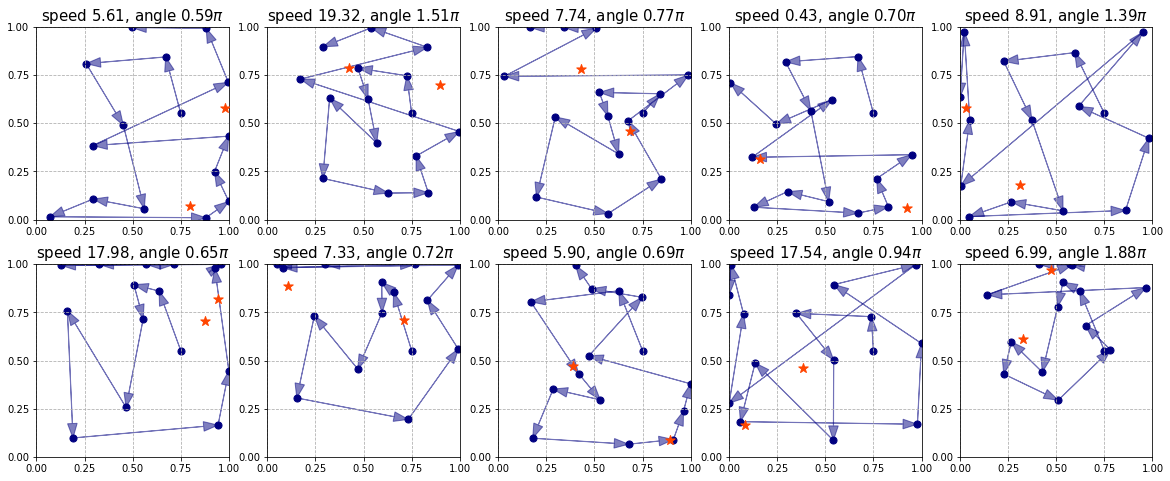

In [9]:
# randomly pick 10 indexes of sample, and draw the designs
# np.random.seed(1369)
idxs = np.random.choice(len(params), 10, replace=False)
plt.figure(figsize=(20, 8))
for i, idx in enumerate(idxs):
    plt.subplot(2, 5, i + 1, aspect='equal')
    param = params[idx].numpy()
    d_hist = ds_hist[idx].numpy()
    y_hist = ys_hist[idx].numpy()
    for i in range(2):
        plt.scatter(param[i*2], param[i*2+1], c='orangered', s=100, marker='*', zorder=10)
    d_old = None
    for d in d_hist:
        plt.scatter(d[0], d[1], c='navy', s=50)
        if d_old is not None:
            plt.arrow(d_old[0], d_old[1], d[0] - d_old[0], d[1] - d_old[1], alpha=0.5, color='navy', head_width=0.05, length_includes_head=True)
        d_old = d
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xticks(np.linspace(0, 1, 5))
    plt.yticks(np.linspace(0, 1, 5))
    plt.grid(ls='--')
    plt.title(f'speed {param[4]:.2f}, angle {param[5]/np.pi:.2f}$\pi$', fontsize=15)

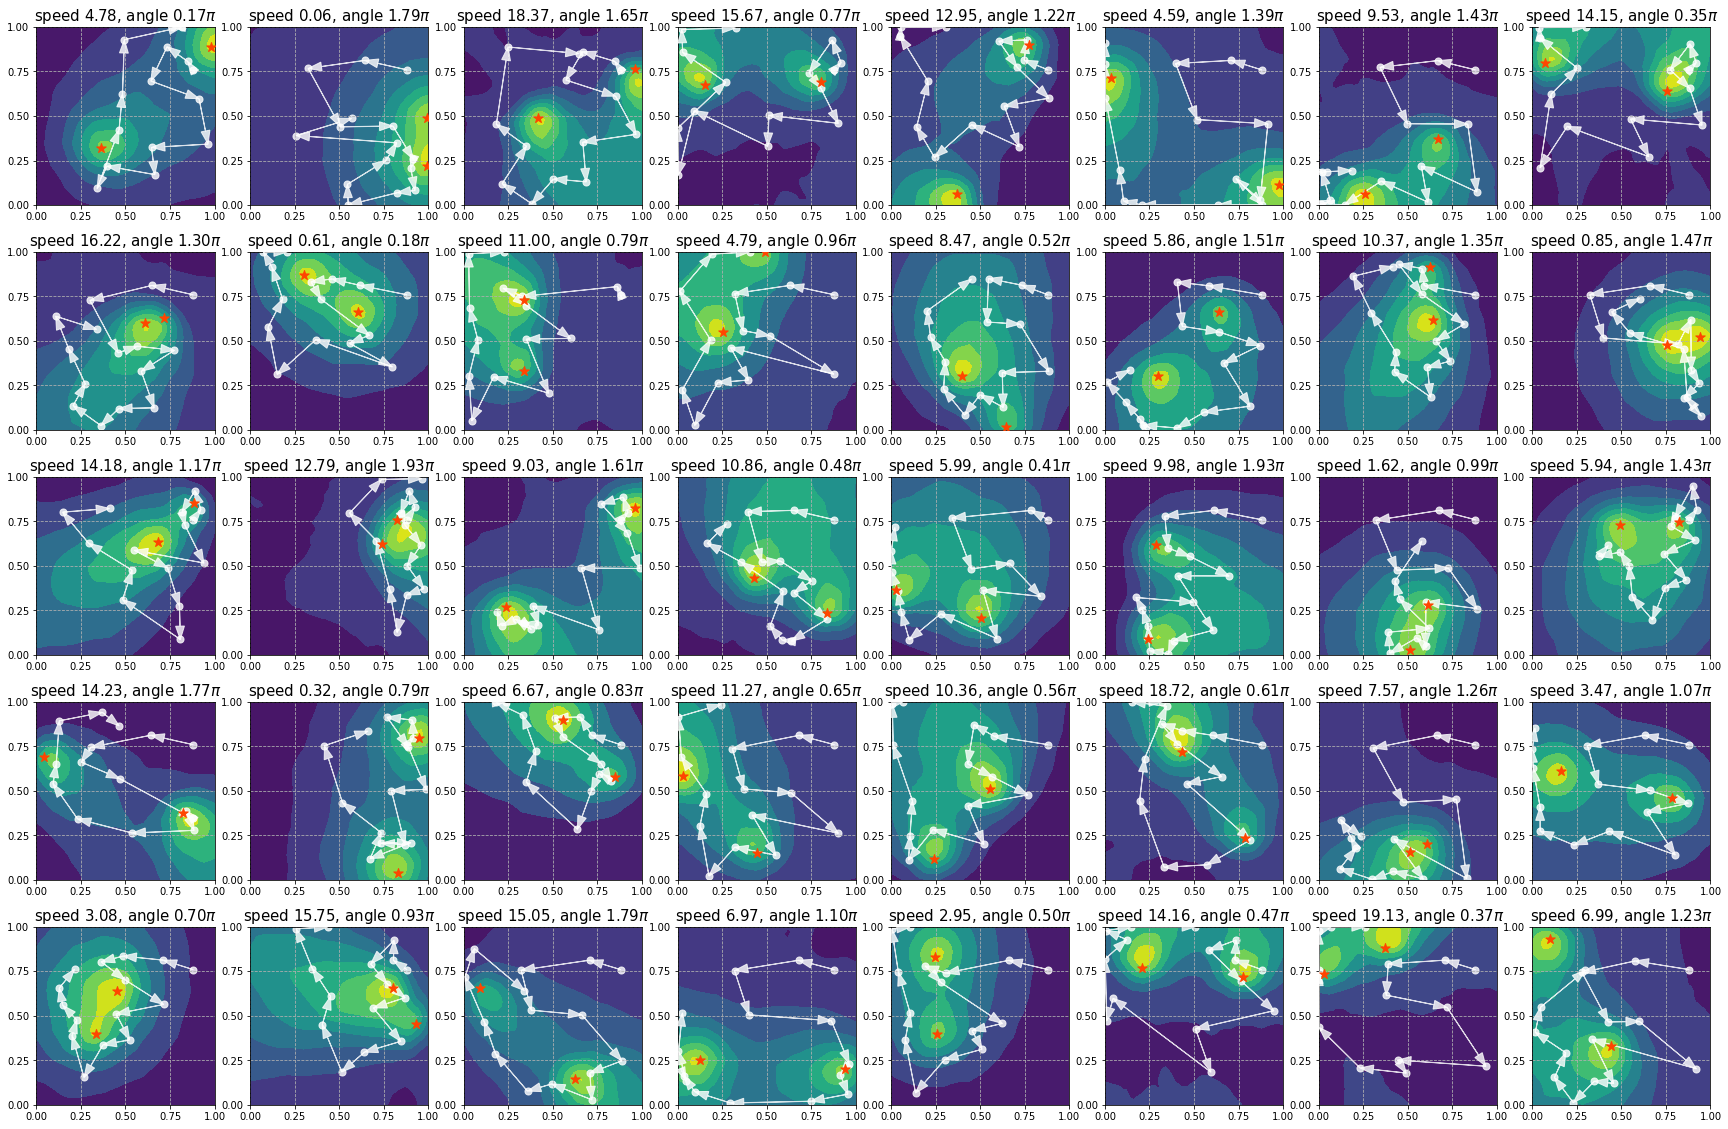

In [112]:
# randomly pick 10 indexes of sample, and draw the designs
# np.random.seed(1369)
idxs = np.random.choice(len(params), 40, replace=False)
plt.figure(figsize=(30, 20))
for i, idx in enumerate(idxs):
    plt.subplot(5, 8, i + 1, aspect='equal')
    x = torch.linspace(0, 1, 51)
    X, Y = torch.meshgrid(x, x, indexing='ij')
    XY = torch.dstack([X, Y])
    XY = XY.reshape(-1, 2)
    with torch.no_grad():
        concentration, _ = vsoed.model.deterministic(h-1, params[idx:idx+1], XY)
    concentration = concentration.reshape(len(x), len(x)).cpu().numpy()
    param = params[idx].cpu().numpy()
    d_hist = ds_hist[idx].cpu().numpy()
    y_hist = ys_hist[idx].cpu().numpy()
    plt.contourf(X, Y, concentration)
    for i in range(2):
        plt.scatter(param[i*2], param[i*2+1], c='orangered', s=100, marker='*', zorder=10)
    d_old = None
    for d in d_hist:
        plt.scatter(d[0], d[1], c='w', s=50, alpha=0.8)
        if d_old is not None:
            plt.arrow(d_old[0], d_old[1], d[0] - d_old[0], d[1] - d_old[1], alpha=0.8, color='w', head_width=0.05, length_includes_head=True, zorder=5)
        d_old = d
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xticks(np.linspace(0, 1, 5))
    plt.yticks(np.linspace(0, 1, 5))
    plt.grid(ls='--')
    plt.title(f'speed {param[4]:.2f}, angle {param[5]/np.pi:.2f}$\pi$', fontsize=15)

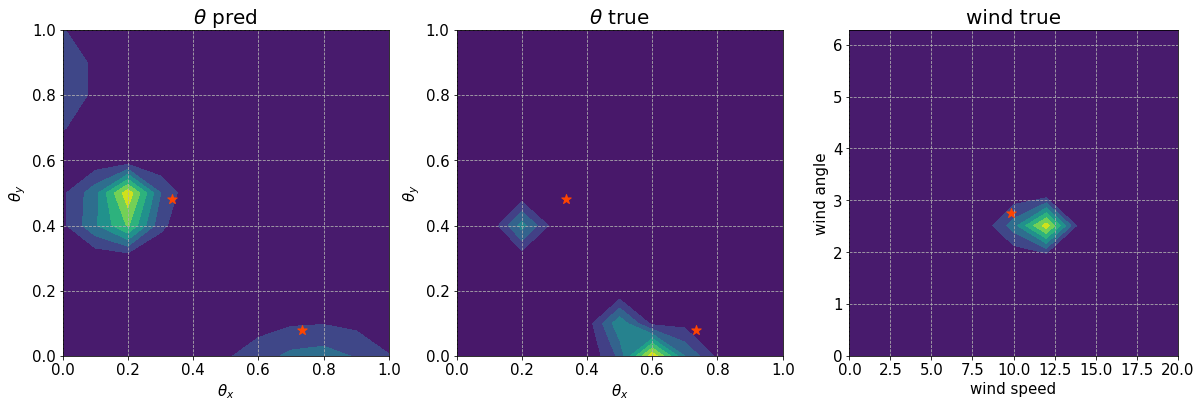

In [113]:
# randomly pick 1 index of samples, and draw the posterior
# np.random.seed(213)
idx = np.random.choice(len(params), 1, replace=False)[0]
# idx = 20
theta_bounds = [[1e-4, 1-1e-4]] * 4
param_bounds =  theta_bounds + [[0, 20], [0, 2 * np.pi]]
n_grid = 11
theta_grids = [np.linspace(theta_bounds[i][0], theta_bounds[i][1], n_grid) for i in range(len(theta_bounds))]
param_grids = [np.linspace(param_bounds[i][0], param_bounds[i][1], n_grid) for i in range(len(param_bounds))]
THETA = np.meshgrid(*theta_grids, indexing='ij')
THETA = np.array(THETA)
THETA = np.moveaxis(THETA, 0, -1)
THETA_tensor = torch.from_numpy(np.array(THETA)).view(-1, len(theta_bounds))
PARAM = np.meshgrid(*param_grids, indexing='ij')
PARAM = np.array(PARAM)
PARAM = np.moveaxis(PARAM, 0, -1)
PARAM_tensor = torch.from_numpy(np.array(PARAM)).view(-1, len(param_bounds))
net = vsoed.post_approx.poi_post_nets[h - 1][0]

param = params[idx].numpy()
d_hist = ds_hist[idx].numpy()
y_hist = ys_hist[idx].numpy()

X = vsoed.post_approx.form_input(h, ds_hist[idx:idx+1], ys_hist[idx:idx+1])
X = X.expand(len(THETA_tensor), -1)
with torch.no_grad():
    logpost_pred = net(X, THETA_tensor)
post_pred = torch.exp(logpost_pred).reshape([n_grid]*len(theta_bounds))
post_pred = post_pred.cpu().numpy()

plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1, aspect='equal')
XY = THETA[:, :, 0, 0, 0:2]
X = XY[:, :, 0]
Y = XY[:, :, 1]
post = post_pred.sum(axis=(-1,-2))
plt.contourf(X, Y, post)
plt.scatter(param[0], param[1], s=100, c='orangered', marker='*')
plt.scatter(param[2], param[3], s=100, c='orangered', marker='*')
plt.title('$\\theta$ pred', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$\\theta_x$', fontsize=15)
plt.ylabel('$\\theta_y$', fontsize=15)
plt.grid(ls='--')
plt.xlim(0, 1)
plt.ylim(0, 1)

logprior_true = vsoed.prior.log_poi_prior(PARAM_tensor)
loglikeli_true = 0
for stage in range(h):
    loglikeli_true += vsoed.loglikeli(h, ys_hist[idx][stage:stage+1], PARAM_tensor, ds_hist[idx][stage:stage+1])
logpost_true = logprior_true + loglikeli_true
post_true = torch.exp(logpost_true).reshape([n_grid]*len(param_bounds))

theta_post_true = post_true.sum(axis=(-1,-2,-3,-4))
plt.subplot(1, 3, 2, aspect='equal')
plt.contourf(X, Y, theta_post_true)
plt.scatter(param[0], param[1], s=100, c='orangered', marker='*')
plt.scatter(param[2], param[3], s=100, c='orangered', marker='*')
plt.title('$\\theta$ true', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$\\theta_x$', fontsize=15)
plt.ylabel('$\\theta_y$', fontsize=15)
plt.grid(ls='--')
plt.xlim(0, 1)
plt.ylim(0, 1)

wind_post_true = post_true.sum(axis=(0,1,2,3))
XY = PARAM[0, 0, 0, 0, :, :, -2:]
X = XY[:, :, 0]
Y = XY[:, :, 1]
plt.subplot(1, 3, 3)
plt.contourf(X, Y, wind_post_true)
plt.scatter(param[4], param[5], s=100, c='orangered', marker='*')
plt.title('wind true', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('wind speed', fontsize=15)
plt.ylabel('wind angle', fontsize=15)
plt.grid(ls='--')
plt.xlim(0, 20)
plt.ylim(0, 2 * np.pi)

plt.show()

# Only interested in goal-oriented (goal)

In [10]:
data_folder = parent_dir + './results/conv_diff/unimodel/goal/'
subfolders = {'gmm': data_folder + 'GMM/',
              'nfs': data_folder + 'NFs/'}

In [11]:
# read in gmm results
hs = [1, 5, 10, 15, 20]
gmm_rwds = {}
for mode in ('terminal', 'incre'):
    gmm_rwds[mode] = np.full((4, 5), np.nan)
    for id in range(4):
        for k, h in enumerate(hs):
            try:
                res = torch.load(subfolders['gmm'] + f'/{mode}_id{id}_h{h}/evaluation_with_post_approx.pt', map_location=device)
                gmm_rwds[mode][id, k] = res['averaged_reward']
            except:
                pass
        

In [12]:
gmm_rwds['incre']

array([[-1.61493444, -1.29964995, -0.79621559, -0.5160799 , -0.32561144],
       [        nan,         nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan]])

In [13]:
gmm_rwds['terminal']

array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]])

/tmp/ipykernel_1441802/256948655.py:6: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(gmm_rwds[mode], axis=0)


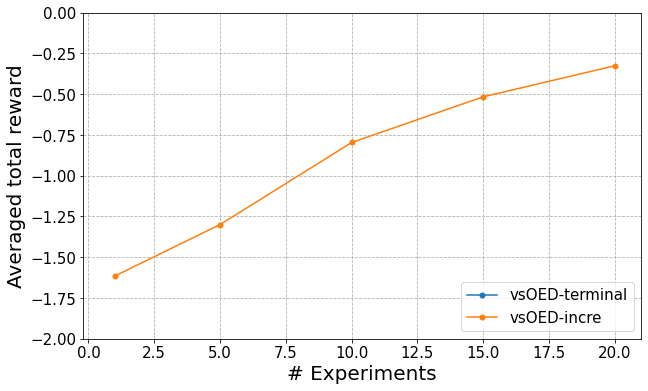

In [14]:
# draw evaluation of each T, compared with limited training
plt.figure(figsize=(10, 6))
markersize = 5
markers = {'gmm':'o'}
for mode in ['terminal', 'incre']:
    mean = np.nanmean(gmm_rwds[mode], axis=0)
    plt.plot(hs, mean, marker=markers['gmm'], markersize=markersize, label=f'vsOED-{mode}', zorder=100)
    # plt.fill_between(hs, mean-2*se, mean+2*se, alpha=0.5, zorder=100)

plt.legend(fontsize=15, loc=4)
plt.xlabel('# Experiments', fontsize=20)
plt.ylabel('Averaged total reward', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(-0.2, 21)
plt.ylim(-2, 0)
plt.grid(ls='--')
plt.show()

In [17]:
# pick a mode , id and horizon, and load the data
post_net_type = 'gmm'
mode = 'incre'
id = 0
h = 15
subfolder = subfolders[post_net_type] + f'/{mode}_id{id}_h{h}/'
eval_data = torch.load(subfolder + 'evaluation_with_post_approx.pt', map_location=device)
print(eval_data['averaged_reward'])
params = eval_data['params']
ds_hist = eval_data['ds_hist']
ys_hist = eval_data['ys_hist']
rewards_hist = eval_data['rewards_hist']
vsoed = joblib.load(subfolder + f'/itr_10000.pkl')

-0.5160799026489258


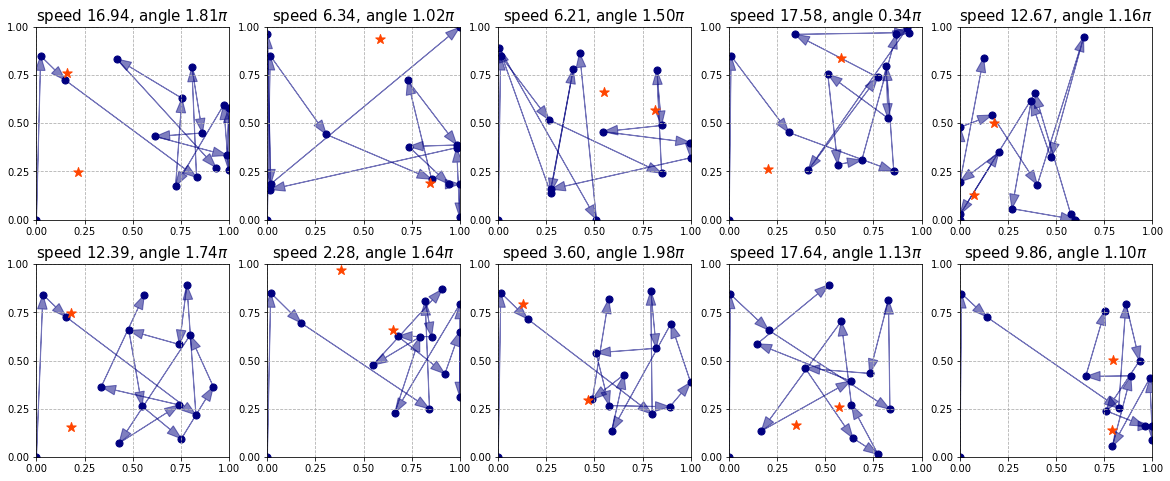

In [18]:
# randomly pick 10 indexes of sample, and draw the designs
# np.random.seed(1369)
idxs = np.random.choice(len(params), 10, replace=False)
plt.figure(figsize=(20, 8))
for i, idx in enumerate(idxs):
    plt.subplot(2, 5, i + 1, aspect='equal')
    param = params[idx].numpy()
    d_hist = ds_hist[idx].numpy()
    y_hist = ys_hist[idx].numpy()
    for i in range(2):
        plt.scatter(param[i*2], param[i*2+1], c='orangered', s=100, marker='*', zorder=10)
    d_old = None
    for d in d_hist:
        plt.scatter(d[0], d[1], c='navy', s=50)
        if d_old is not None:
            plt.arrow(d_old[0], d_old[1], d[0] - d_old[0], d[1] - d_old[1], alpha=0.5, color='navy', head_width=0.05, length_includes_head=True)
        d_old = d
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xticks(np.linspace(0, 1, 5))
    plt.yticks(np.linspace(0, 1, 5))
    plt.grid(ls='--')
    plt.title(f'speed {param[4]:.2f}, angle {param[5]/np.pi:.2f}$\pi$', fontsize=15)

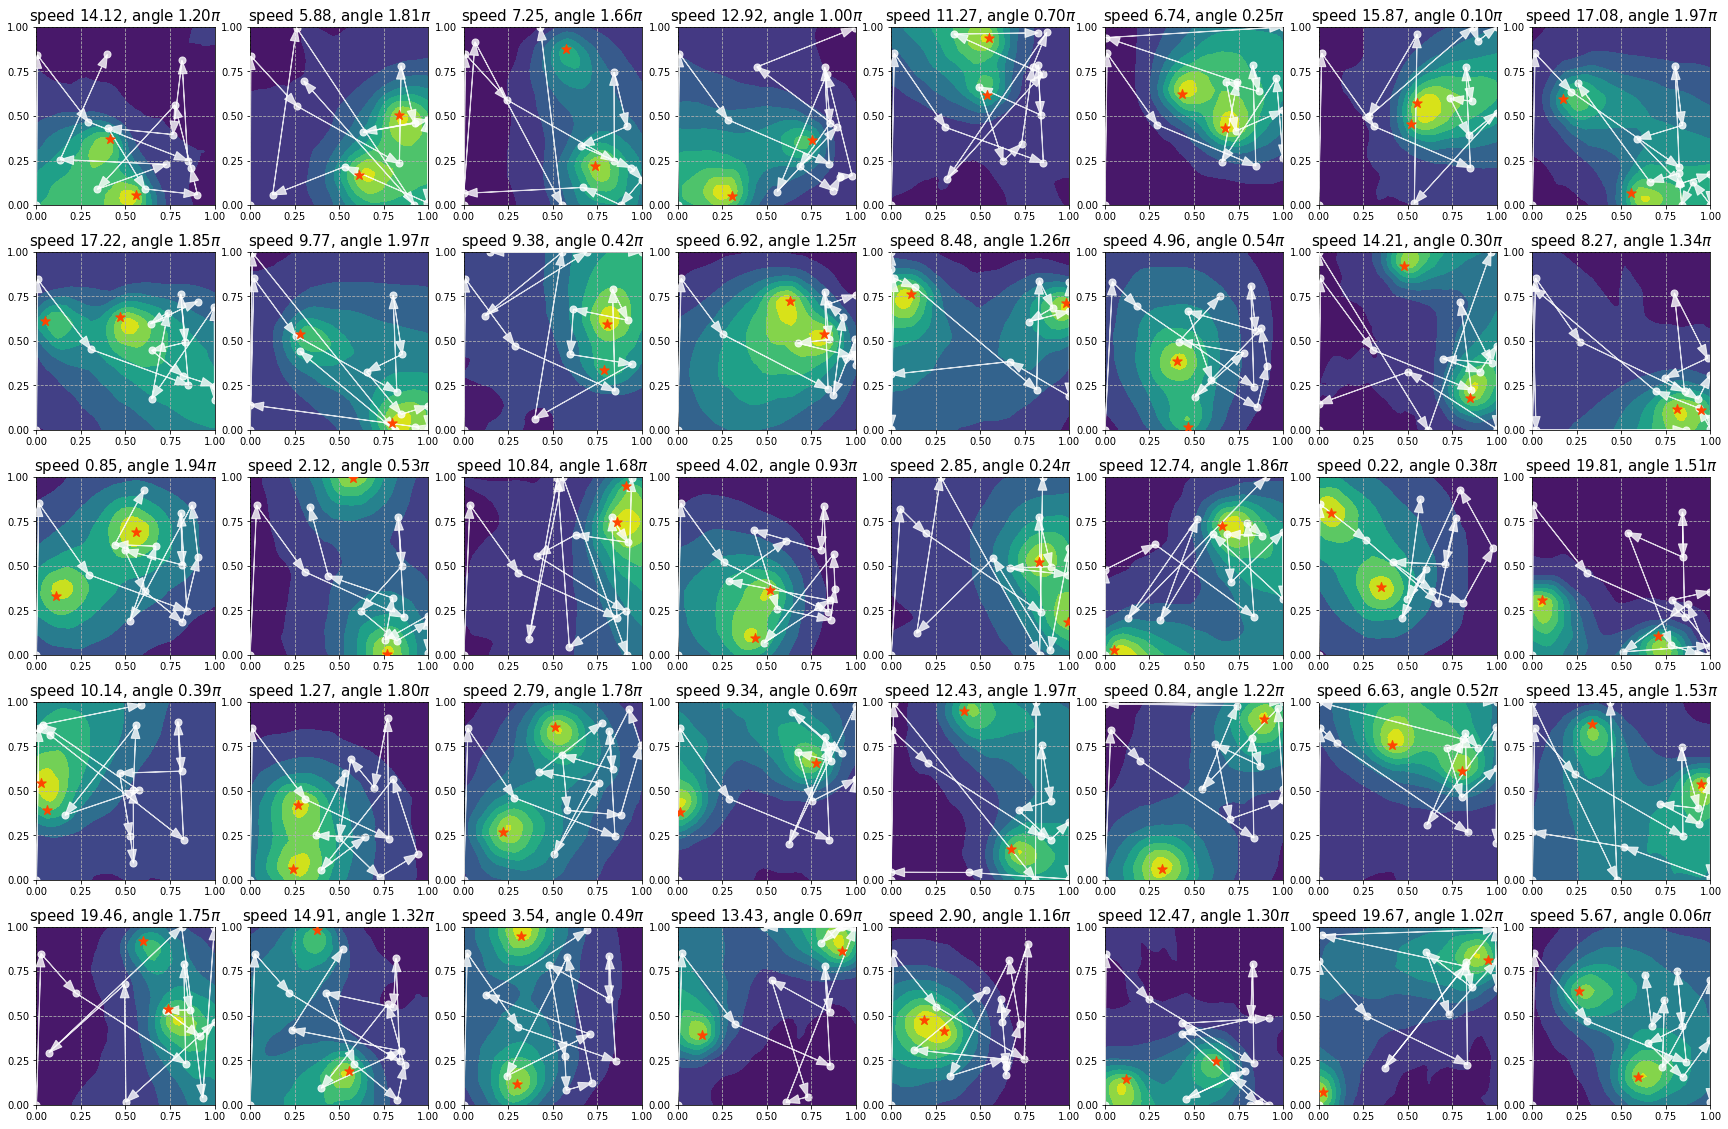

In [19]:
# randomly pick 10 indexes of sample, and draw the designs
# np.random.seed(1369)
idxs = np.random.choice(len(params), 40, replace=False)
plt.figure(figsize=(30, 20))
for i, idx in enumerate(idxs):
    plt.subplot(5, 8, i + 1, aspect='equal')
    x = torch.linspace(0, 1, 51)
    X, Y = torch.meshgrid(x, x, indexing='ij')
    XY = torch.dstack([X, Y])
    XY = XY.reshape(-1, 2)
    with torch.no_grad():
        concentration, _ = vsoed.model.deterministic(h-1, params[idx:idx+1], XY)
    concentration = concentration.reshape(len(x), len(x)).cpu().numpy()
    param = params[idx].cpu().numpy()
    d_hist = ds_hist[idx].cpu().numpy()
    y_hist = ys_hist[idx].cpu().numpy()
    plt.contourf(X, Y, concentration)
    for i in range(2):
        plt.scatter(param[i*2], param[i*2+1], c='orangered', s=100, marker='*', zorder=10)
    d_old = None
    for d in d_hist:
        plt.scatter(d[0], d[1], c='w', s=50, alpha=0.8)
        if d_old is not None:
            plt.arrow(d_old[0], d_old[1], d[0] - d_old[0], d[1] - d_old[1], alpha=0.8, color='w', head_width=0.05, length_includes_head=True, zorder=5)
        d_old = d
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xticks(np.linspace(0, 1, 5))
    plt.yticks(np.linspace(0, 1, 5))
    plt.grid(ls='--')
    plt.title(f'speed {param[4]:.2f}, angle {param[5]/np.pi:.2f}$\pi$', fontsize=15)

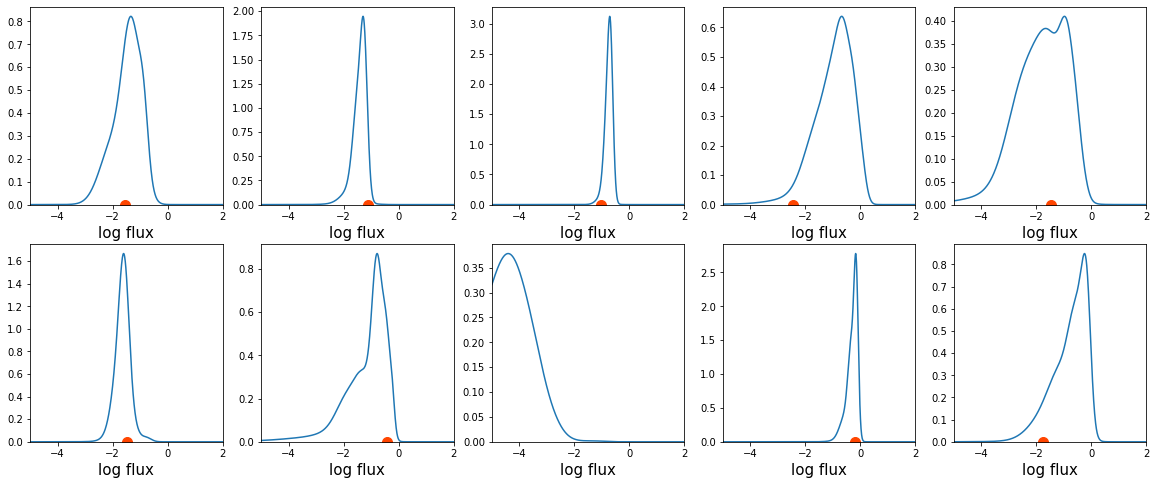

In [20]:
# randomly pick 10 index of samples, and draw the posterior
# np.random.seed(1369)
idxs = np.random.choice(len(params), 10, replace=False)
param_bounds =  [-5, 2]
n_grid = 1001
param_grids = np.linspace(param_bounds[0], param_bounds[1], n_grid)
PARAM_tensor = torch.from_numpy(param_grids).view(-1, 1)
net = vsoed.post_approx.goal_post_nets[h - 1][0]

plt.figure(figsize=(20, 8))
for i, idx in enumerate(idxs):
    plt.subplot(2, 5, i + 1)
    param = params[idx].numpy()
    d_hist = ds_hist[idx].numpy()
    y_hist = ys_hist[idx].numpy()

    X = vsoed.post_approx.form_input(h, ds_hist[idx:idx+1], ys_hist[idx:idx+1])
    X = X.expand(len(PARAM_tensor), -1)
    with torch.no_grad():
        logpost_pred = net(X, PARAM_tensor)
    post_pred = torch.exp(logpost_pred)
    post_pred = post_pred.cpu().numpy()
    plt.plot(param_grids, post_pred)
    plt.scatter(param[-1], 0, s=100, c='orangered')
    
    plt.xlim(*param_bounds)
    plt.ylim(0, )
    plt.xlabel('log flux', fontsize=15)

plt.show()

In [120]:
# get the gaussian kde
from scipy.stats import gaussian_kde
contrast_params = vsoed.prior_rvs(int(1e6))
kde = gaussian_kde(contrast_params[:, -1])

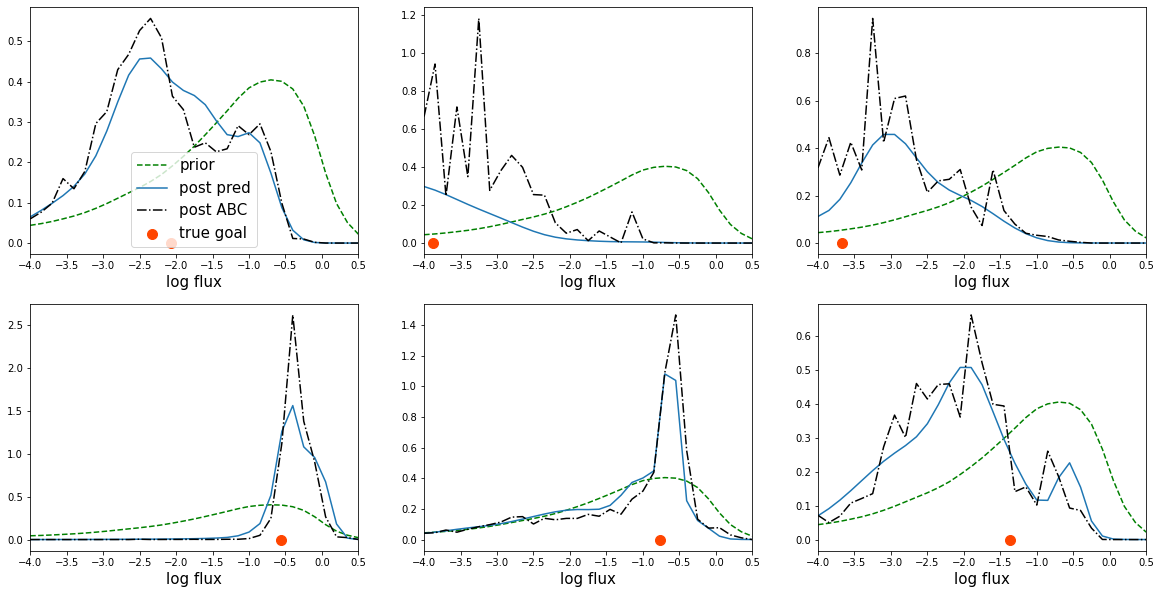

In [121]:
# randomly pick 5 index of samples, and draw the posterior
# np.random.seed(1369)
idxs = np.random.choice(len(params), 6, replace=False)
param_bounds =  [-4, 0.5]
n_grid = 31
param_grids = np.linspace(param_bounds[0], param_bounds[1], n_grid)
prior_pdf = kde.pdf(param_grids)
PARAM_tensor = torch.from_numpy(param_grids).view(-1, 1)
net = vsoed.post_approx.goal_post_nets[h - 1][0]
accept_diff = 3e-2

plt.figure(figsize=(20, 10))
for i, idx in enumerate(idxs):
    plt.subplot(2, 3, i + 1)
    param = params[idx].numpy()
    d_hist = ds_hist[idx].numpy()
    y_hist = ys_hist[idx].numpy()

    X = vsoed.post_approx.form_input(h, ds_hist[idx:idx+1], ys_hist[idx:idx+1])
    X = X.expand(len(PARAM_tensor), -1)
    with torch.no_grad():
        logpost_pred = net(X, PARAM_tensor)
    post_pred = torch.exp(logpost_pred)
    post_pred = post_pred.cpu().numpy()
    plt.plot(param_grids, prior_pdf, label='prior', color='g', ls='--')
    plt.plot(param_grids, post_pred, label='post pred')
    plt.scatter(param[-1], 0, s=100, c='orangered', label='true goal')

    post_true = np.zeros(len(param_grids))
    for j, param_grid in enumerate(param_grids):
        accept_idxs = torch.abs(contrast_params[:, -1] - param_grid) < accept_diff
        used_params = contrast_params[accept_idxs]
        loglikeli = 0
        for k in range(h):
            loglikeli += vsoed.model.loglikeli(k, ys_hist[idx][k:k+1], used_params, ds_hist[idx][k:k+1])
        likeli = torch.exp(loglikeli)
        goal_likeli = likeli.mean().cpu().numpy()
        post_true[j] = prior_pdf[j] * goal_likeli
    post_true /= post_true.sum() * (param_grids[1] - param_grids[0])
    plt.plot(param_grids, post_true, label='post ABC', color='black', ls='-.')
    
    
    plt.xlim(*param_bounds)
    # plt.ylim(0, 15)
    plt.xlabel('log flux', fontsize=15)
    if i == 0:
        plt.legend(fontsize=15)

plt.show()

In [44]:
# # compare vertical designs and horizontal designs
# theta = torch.tensor([[0, 0, 0, 0]])
# logflux = vsoed.model.flux(theta)
# param = torch.cat([theta, logflux], dim=-1)
# # vertical designs
# dx = 2
# # dy = torch.linspace(-2, 2, 3)
# dy = torch.tensor([0])
# ds_ver = torch.vstack([torch.zeros(len(dy)) + dx, dy]).T
# # horizontal designs
# ds_hor = ds_ver.clone()
# tmp = ds_hor[:, 0].clone()
# ds_hor[:, 0] = ds_hor[:, 1]
# ds_hor[:, 1] = tmp
# ys_ver = torch.empty(len(dy), 1)
# ys_hor = ys_ver.clone()
# for k in range(len(ds_ver)):
#     ys_ver[k] = vsoed.model.model(stage, param, ds_ver[k:k+1])
#     ys_hor[k] = vsoed.model.model(stage, param, ds_hor[k:k+1])
# plt.figure(figsize=(15, 6))
# plt.subplot(1, 2, 1, aspect='equal')
# plt.scatter(param[0][0], param[0][1], s=100, c='orangered', label='source')
# plt.scatter(ds_ver[:, 0], ds_ver[:, 1], s=100, marker='x', c='black', label='vertical ds', zorder=2)
# plt.scatter(ds_hor[:, 0], ds_hor[:, 1], s=100, marker='^', c='c', label='vertical ds')
# plt.legend(fontsize=15, loc=3)
# plt.xlim(-4, 4)
# plt.ylim(-4, 4)

# plt.subplot(1, 2, 2)
# post_ver = np.zeros(len(param_grids))
# post_hor = np.zeros(len(param_grids))
# for j, param_grid in enumerate(param_grids):
#     accept_idxs = torch.abs(contrast_params[:, -1] - param_grid) < accept_diff
#     used_params = contrast_params[accept_idxs]
#     loglikeli_ver = 0
#     loglikeli_hor = 0
#     for k in range(len(ds_ver)):
#         loglikeli_ver += vsoed.model.loglikeli(k, ys_ver[k:k+1], used_params, ds_ver[k:k+1])
#         loglikeli_hor += vsoed.model.loglikeli(k, ys_hor[k:k+1], used_params, ds_hor[k:k+1])
#     likeli_ver = torch.exp(loglikeli_ver)
#     likeli_hor = torch.exp(loglikeli_hor)
#     goal_likeli_ver = likeli_ver.mean().cpu().numpy()
#     goal_likeli_hor = likeli_hor.mean().cpu().numpy()
#     post_ver[j] = prior_pdf[j] * goal_likeli_ver
#     post_hor[j] = prior_pdf[j] * goal_likeli_hor
# post_ver /= post_ver.sum() * (param_grids[1] - param_grids[0])
# post_hor /= post_hor.sum() * (param_grids[1] - param_grids[0])

# plt.plot(param_grids, prior_pdf, label='prior', color='g', ls='--')
# plt.plot(param_grids, post_ver, label='vertical ds', color='black', ls='-')
# plt.plot(param_grids, post_hor, label='horizontal ds', color='c', ls='-.')
# plt.scatter(param[0][-1].cpu().numpy(), 0, s=100, c='orangered', label='true goal')
# plt.legend(fontsize=15)
# plt.xlim(*param_bounds)
# plt.ylim(0, 15)
# plt.xlabel('log flux', fontsize=15)